
# **Data Exploration of the Dataset** 
The goal of data exploration of this dataset is to gain insights and understanding of the data by summarizing its main characteristics, identifying patterns and trends, and checking for any inconsistencies or anomalies. This can help inform decision making and provide a basis for further analysis and modeling. Data exploration can also help identify potential problems or limitations with the dataset, such as missing or incomplete data.

1.  Distribution of user ratings

2.  Top 10 of Highest Average Rating

3.  Top 10 Most Popular Anime

4.  Top 10 Most Reviewed Anime

5.  Classification by Genres
6.  Classification by Studios
7.  Classification by Souces
8.  Watched Anime


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install pyspark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 199 kB 42.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4e449f7218511cece978f3377dc1ea4bc90efc7fe6685305d8cc9e8ede32deb3
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from google.colab import drive

GDRIVE_DIR = "/content/gdrive"

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4051").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G').set('spark.worker.memory','12G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
GDRIVE_RATINGS_FILE = "../models/animelist.csv"

spark = SparkSession.builder.appName("Recommendation").getOrCreate()
ratings_df = spark.read.load(GDRIVE_RATINGS_FILE,  format="csv",  sep=",",  inferSchema="true",  header="true" )

In [ ]:
GDRIVE_CONTENT_FILE = "../models/anime.csv"

content_df = spark.read.load(GDRIVE_CONTENT_FILE,  format="csv",  sep=",",  inferSchema="true",  header="true" )

## **1) Distribution of user ratings**
We can see that we are dealing with a large number of unrated reviews. It's also important to consider the number of reviews that don't have a numerical score

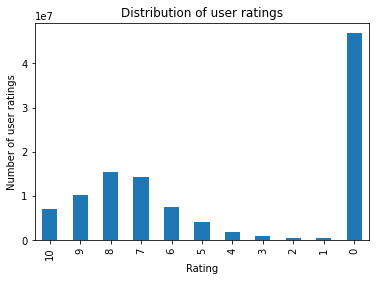

In [ ]:
# Distribution of user ratings
from pyspark.sql import functions as f

ratings_hist=(ratings_df
 .groupBy(f.col("rating")).count()
 .sort(f.col("rating").desc())        
).toPandas()

ratings_hist.plot.bar("rating","count")
plt.title("Distribution of user ratings")
plt.xlabel("Rating")
plt.ylabel("Number of user ratings")
plt.legend().remove()

## **2) Top 10 of Highest Average Rating**
A high average rating for an anime does not necessarily mean that it is the most popular. While a high average rating may indicate that the anime is well-liked by those who have watched it, there are many other factors that can affect its popularity. For example, an anime with a high average rating may not be widely known or may not have been heavily promoted, which could limit its overall popularity. On the other hand, an anime with a lower average rating may have a larger audience and be more widely known, making it more popular overall.



In [ ]:
data2 = content_df.withColumn("Score", content_df["Score"].cast('float'))#we loose 5.144 rows
data2 = data2.orderBy(col("Score").desc())
display_data = data2.limit(10)
display_data.show(truncate=False)


+------+------------------------------------+-----+-------------------------------------------------------------------+-------------------------------+----------------------------------+-----+--------+---------------------------+-----------+-----------------------------------------------------------------------------------------------------------------+------------------------------+---------------------+------------+---------------+------------------------------+------+----------+---------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+
|MAL_ID|Name                                |Score|Genres                                                             |English name                   |Japanese name                     |Type |Episodes|Aired                      |Premiered  |Producers                                                                                                        |Licens

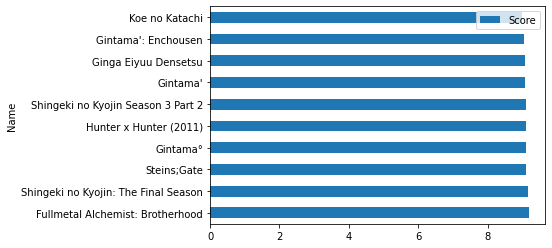

In [ ]:
review_statistics = display_data.toPandas()
review_statistics.plot.barh(x='Name', y='Score')

## **3) Top 10 Most Popular Anime**
Let's analyze the popularity feature of the dataset: position based in the the number of users who have added the anime to their list.

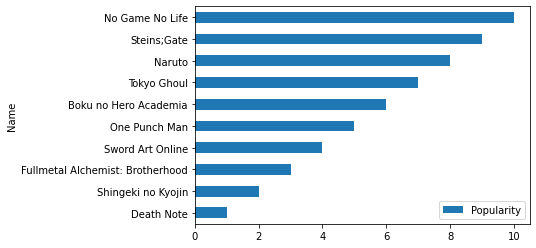

In [ ]:
#print(f'Data types of all the columns is : {content_df.dtypes}')
data2 = content_df.withColumn("Popularity", content_df["Popularity"].cast('int'))
data2 = data2.filter("Popularity != 0")
data2 = data2.orderBy(col("Popularity").asc())
data2 = data2.na.drop()

display_data = data2.limit(10)

review_statistics = display_data.toPandas()
review_statistics.plot.barh(x='Name', y='Popularity')

## **4) Top 10 Most Reviewed Anime**
Having a large number of reviews for an anime does not necessarily mean that it is popular. There are many factors that can affect an anime's popularity, and the number of reviews is just one of them. In the case of Death Note, it's possible that the anime has a large number of reviews because it is a widely known and well-regarded anime. However, it's also possible that the anime has a large number of reviews because it has been heavily promoted, or because it has a unique or intriguing premise that has attracted a lot of attention. So, while the number of reviews can be a useful metric to consider, it should be taken in context with other factors that can affect an anime's popularity.

In [ ]:
c2 = content_df.withColumnRenamed("MAL_ID","anime_id")
c2 = c2.select(c2.anime_id, c2.Name)
merged_df  = ratings_df.join(c2, ["anime_id"])
merged_df = merged_df.select(merged_df.anime_id, merged_df.Name, merged_df.rating)
ok = merged_df.groupBy("Name").count().orderBy(col("Name"))
data2 = ok.sort(col("count").desc())
display_data = data2.limit(10)
display_data.show()
review_statistics = display_data.toPandas()

+--------------------+------+
|                Name| count|
+--------------------+------+
|          Death Note|238790|
|  Shingeki no Kyojin|216767|
|    Sword Art Online|209919|
|Fullmetal Alchemi...|201611|
|           Toradora!|196190|
|        Angel Beats!|194652|
|Code Geass: Hangy...|193770|
|         Steins;Gate|192783|
|              Naruto|180244|
|         Mirai Nikki|178385|
+--------------------+------+



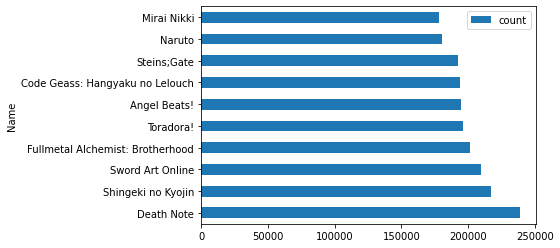

In [ ]:
review_statistics.plot.barh(x='Name', y='count')


## **5) Classification by Genres**
The best feature that could help users find 
content that matches with their interests

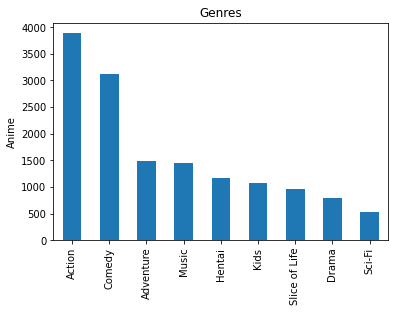

In [ ]:
content_pdf = content_df.toPandas()
top_genres = content_pdf['Genres'].apply(lambda x: x.split(',')[0]).value_counts()
top_10_genres = content_pdf['Genres'].apply(lambda x: x.split(',')[0]).value_counts().head(9).plot(kind='bar')
plt.ylabel('Anime by genres')
plt.title('Genres');

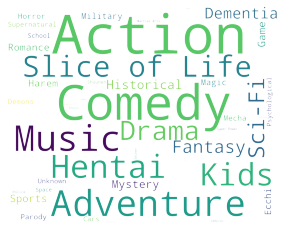

In [ ]:
from wordcloud import WordCloud

content_pdf = content_df.toPandas()
top_genres = content_pdf['Genres'].apply(lambda x: x.split(',')[0]).value_counts()

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA",max_words=70,max_font_size=200, width=1000, height=800,random_state=42,).generate_from_frequencies(top_genres)

plt.imshow(wc)
plt.axis('off')
plt.show()

## **6) Classification by Studios**
We can see that most of the anime have an Unknown studios. Having a large number of missing or unknown values can make it harder to accurately predict user preferences and make recommendations.

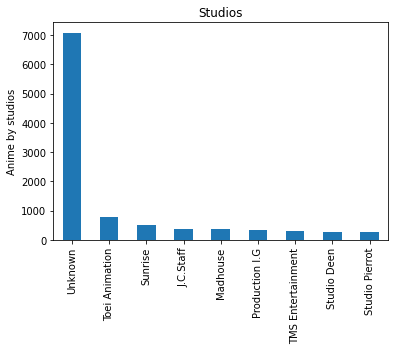

In [ ]:
top_studios = content_pdf['Studios'].apply(lambda x: x.split(',')[0]).value_counts()
top_10_studios = content_pdf['Studios'].apply(lambda x: x.split(',')[0]).value_counts().head(9).plot(kind='bar')
plt.ylabel('Anime by studios')
plt.title('Studios');

## **7) Classification by Sources**

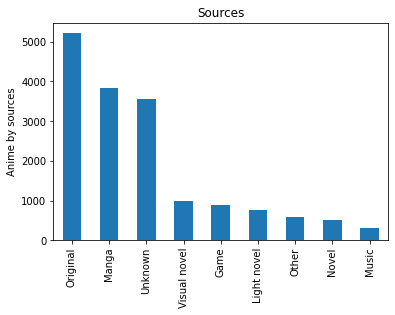

In [ ]:
top_sources = content_pdf['Source'].apply(lambda x: x.split(',')[0]).value_counts()
top_10_sources = content_pdf['Source'].apply(lambda x: x.split(',')[0]).value_counts().head(9).plot(kind='bar')
plt.ylabel('Anime by sources')
plt.title('Sources');

# **8) Watched Anime**

The most of the users reviewed only one anime. There are various users who have reviewed more than 10000 anime.

In [ ]:
content_pdf = content_df.toPandas()

In [ ]:
users = ratings_df.groupBy('user_id').count()
users = users.withColumnRenamed("count","tot_viewed")
watched_anime = users.groupBy('tot_viewed').count().orderBy('tot_viewed',ascending=True)
watched_anime = watched_anime.limit(40)
watched_anime_pdf = watched_anime.toPandas()

In [ ]:
watched_anime.show()


+----------+-----+
|tot_viewed|count|
+----------+-----+
|         1| 2892|
|         2| 1996|
|         3| 1673|
|         4| 1594|
|         5| 1451|
|         6| 1390|
|         7| 1295|
|         8| 1118|
|         9| 1123|
|        10| 1134|
|        11| 1003|
|        12|  937|
|        13|  991|
|        14|  916|
|        15|  842|
|        16|  857|
|        17|  924|
|        18|  848|
|        19|  866|
|        20|  900|
+----------+-----+
only showing top 20 rows



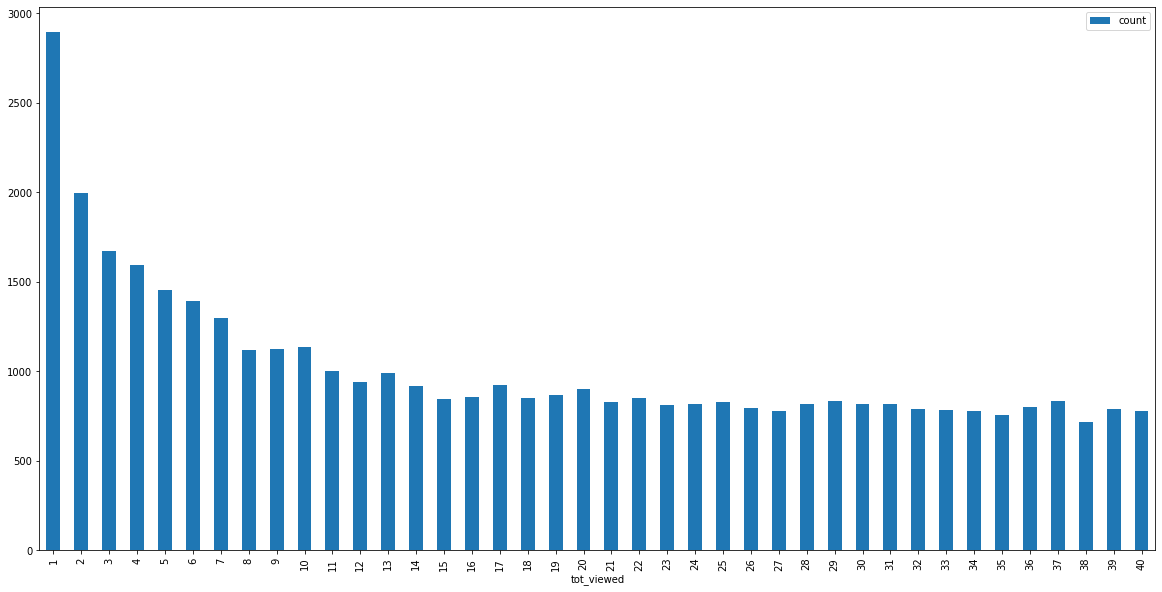

In [ ]:
watched_anime_pdf.plot(x="tot_viewed", y="count", kind="bar", figsize=(20, 10))
# display plot
plt.show()

In [ ]:
watched_anime.orderBy('tot_viewed', ascending=False).show(100)

+----------+-----+
|tot_viewed|count|
+----------+-----+
|     17546|    1|
|     17534|    1|
|     17533|    1|
|     17526|    1|
|     17520|    1|
|     17517|    1|
|     17509|    1|
|     17410|    1|
|     17204|    1|
|     16775|    1|
|     16774|    1|
|     16639|    1|
|     16557|    1|
|     15993|    1|
|     15688|    1|
|     15668|    1|
|     15600|    1|
|     15381|    1|
|     15197|    1|
|     14638|    1|
|     14606|    1|
|     14504|    1|
|     14429|    1|
|     13857|    1|
|     13696|    1|
|     12914|    1|
|     12809|    1|
|     12594|    1|
|     12555|    1|
|     12392|    1|
|     11938|    1|
|     11724|    1|
|     11716|    1|
|     11564|    1|
|     11300|    1|
|     11115|    1|
|     11103|    1|
|     10960|    1|
|     10901|    1|
|     10208|    1|
|      9781|    1|
|      9701|    1|
|      9633|    1|
|      9005|    1|
|      8999|    1|
|      8943|    1|
|      8897|    1|
|      8724|    1|
|      8709|    1|
|      8666|